In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf


In [131]:
# GLD_data = yf.download('GLD',start = '2021-11-30',end='2024-11-30')
# GDX_data = yf.download('GDX',start = '2021-11-30',end='2024-11-30')

In [132]:
# GLD_data.to_csv('GLD_3years_data_from_nov2021.csv')
# GDX_data.to_csv('GDX_3years_data_from_nov2021.csv')

In [133]:
df1 = pd.read_csv('datasets/GLD_3years_data_from_nov2021.csv')
df2 = pd.read_csv('datasets/GDX_3years_data_from_nov2021.csv')

In [134]:
df = pd.merge(df1,df2,on='Date',suffixes=('_GLD','_GDX'))
df.set_index('Date',inplace = True)

In [135]:
df.sort_index(inplace = True)
trainset = np.arange(0,510)
testset = np.arange(len(trainset),df.shape[0])

OLS is ordinary least square(a statistical method for linear regression)

a technique used to model the relationship between one dependent variable (what you are trying to predict) and one or more independent variables (the factors you believe affect the dependent variable).

For example, you may want to predict the price of GLD (Gold ETF) based on the price of GDX (gold-mining stocks). You would treat the price of GLD as the dependent variable and the price of GDX as the independent variable.

OLS tries to find the best line of fit that minimizes the distance between the predicted values (from the model) and the actual values (from the data). It does this by adjusting the parameters (the slope and intercept) to reduce the total error (the difference between the predicted and actual values).

In [136]:
#dependent variable(y axis = GLD)
# .iloc[trainset] is used to select specific rows from the adj close gld column
y_train = df.loc[:,'Adj Close_GLD'].iloc[trainset]
#independent variable(x axis = GDX)
x_train = df.loc[:,'Adj Close_GDX'].iloc[trainset]



In [137]:
# add constant to x_train for intercept term in the regression(y intercept)
x_train = sm.add_constant(x_train)

In [138]:
#fit the ols model
model = sm.OLS(y_train,x_train)
# This fits the model to the training data, finding the optimal coefficients (slope and intercept) 
# that minimize the difference between the predicted values and the actual values.
results =model.fit()

#include parameters,intercept and the slope
hedgeRatio = results.params

Hedge ratio

A coefficient that indicates how much of one asset (e.g., GDX) you need to hedge exposure to another asset (e.g., GLD).

In [139]:
hedgeRatio

const            115.952098
Adj Close_GDX      1.956506
dtype: float64

Spread:

The spread represents the difference between the price of one asset (GLD) and the adjusted price of another asset (GDX), scaled by the hedge ratio.

spread=Price of GLD−(hedge ratio×Price of GDX)

In [140]:
spread = df.loc[:,'Adj Close_GLD']-hedgeRatio.iloc[1]*df.loc[:,'Adj Close_GDX']

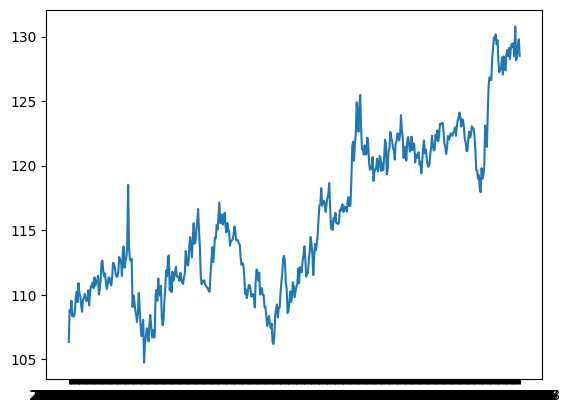

In [141]:
plt.plot(spread.iloc[trainset])


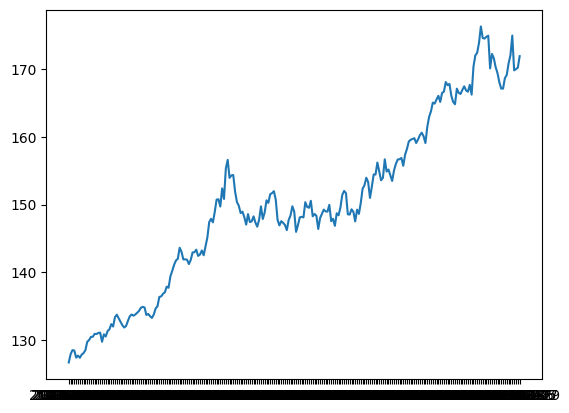

In [142]:
plt.plot(spread.iloc[testset])

z score standardization


In [143]:
spreadMean = np.mean(spread[trainset])
spreadSTD = np.std(spread[trainset])

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_72564\3912587597.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spreadMean = np.mean(spread[trainset])
C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_72564\3912587597.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spreadSTD = np.std(spread[trainset])


In [159]:
#calculate z score standardization
df['zscore'] = (spread-spreadMean)/spreadSTD

In [145]:
df['positions_GLD_Long'] = 0
df['positions_GDX_Long'] = 0
df['positions_GLD_Short'] = 0
df['positions_GDX_Short'] = 0

In [ ]:
#short spread
#Ensure that positions are correctly updated for intermediate z-scores (-1 <= z <= 1).
df.loc[df.zscore>=2,('positions_GLD_Short','positions_GDX_Short')] = [-1,1]

#exit short spread
df.loc[df.zscore<=1,('positions_GLD_long','positions_GDX_Long')] = 0

In [147]:
#buy spread
df.loc[df.zscore<=-2,('positions_GLD_long','positions_GDX_Long')] = [-1,1]
#exit long spread
df.loc[df.zscore>=-1,('positions_GLD_Short','positions_GDX_Short')] = 0


In [148]:
#ensure existing positions are carried forward unless there is an exit signal
df.fillna(method = 'ffill',inplace = True)

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_72564\3304110208.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method = 'ffill',inplace = True)


In [149]:
positions_Long = df.loc[:,('positions_GLD_long','positions_GDX_Long')]
positions_Short = df.loc[:,('positions_GLD_Short','positions_GDX_Short')]
positions = np.array(positions_Long)+ np.array(positions_Short)

In [150]:
positions = pd.DataFrame(positions)

In [151]:
dailyret = df.loc[:,('Adj Close_GLD', 'Adj Close_GDX')].pct_change()

In [152]:
pnl = (np.array(positions.shift())*np.array(dailyret)).sum(axis=1)

In [153]:
sharpeTrainSet = np.sqrt(510)*np.mean(pnl[trainset[1:]])/np.std(pnl[trainset[1:]])

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_72564\4124146583.py:1: RuntimeWarning: invalid value encountered in scalar divide
  sharpeTrainSet = np.sqrt(510)*np.mean(pnl[trainset[1:]])/np.std(pnl[trainset[1:]])


In [154]:
sharpeTrainSet

nan

In [155]:
sharpeTestSet = np.sqrt(252)*np.mean(pnl[testset[1:]])/np.std(pnl[testset[1:]])

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_72564\2701397576.py:1: RuntimeWarning: invalid value encountered in scalar divide
  sharpeTestSet = np.sqrt(252)*np.mean(pnl[testset[1:]])/np.std(pnl[testset[1:]])


In [156]:
sharpeTestSet

nan

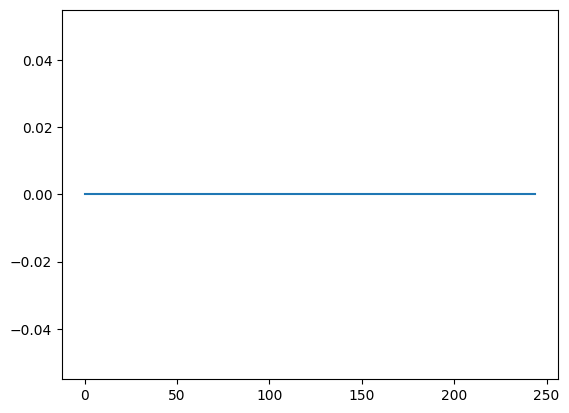

In [157]:
plt.plot(np.cumsum(pnl[testset]))
# positions.to_pickle('example3_6_positions')